<a href="https://colab.research.google.com/github/jacksonmcl/Federal_Funds_Rate_Model/blob/main/3.%20Model%20Training/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github Setup

In [1]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
!git -C "Federal_Funds_Rate_Model" pull || git clone https://github.com/jacksonmcl/Federal_Funds_Rate_Model.git "Federal_Funds_Rate_Model"

fatal: cannot change to 'Federal_Funds_Rate_Model': No such file or directory
Cloning into 'Federal_Funds_Rate_Model'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 181 (delta 88), reused 71 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (181/181), 4.64 MiB | 4.72 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [3]:
!cd ..
!pwd

/content


#Imports & Data

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

from datetime import datetime
from functools import reduce
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

dfs = {}

# Define the valid rates in increments of 25 basis points
valid_rates = np.arange(0.00, 50.00, 0.25)

# Function to convert continuous rates into categorical labels
def convert_to_category(y_values, valid_rates):
    return np.digitize(y_values, valid_rates) - 1  # -1 because np.digitize indexes from 1


In [5]:
dfs['Federal_Funds_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Federal_Funds_Rate.csv')
dfs['Lagged_FFER'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Lagged_FFR.csv')

dfs['Discount_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Discount_Rate.csv')
dfs['Prime_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Prime_Loan_Rate.csv')

dfs['Consumer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Consumer_Price_Index.csv')
dfs['Producer_Price_Index'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Producer_Price_Index.csv')
dfs['Personal_Consumption_Expenditure'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Personal_Consumption_Expenditures.csv')

dfs['Unemployment_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Unemployment_Rate.csv')
dfs['Mortgage_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Mortgage_Rate.csv')
dfs['Auto_Loan_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/2. Data Visualization/clean_Auto_Loan_Rate.csv')

ffr_df = dfs.pop('Federal_Funds_Rate')

# Lagged Federal Funds Effective Rate LSTM
Using the past __ months of data on the Federal Funds Effective Rate
predict the value for the next months FFER

In [6]:
ffr_df.drop(columns = ['Value', 'ChangePercentYear'], axis=1, inplace=True)
ffr_df.dropna(inplace=True)
len(ffr_df)

844

In [7]:
#Use last 10 years for tests
#844 - (12*10) = 724

ffr_train = ffr_df.iloc[:724]
ffr_test = ffr_df.iloc[724:]

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(ffr_train.set_index('Date'))
scaled_ffr_train = scaler.transform(ffr_train.set_index('Date'))
scaled_ffr_test = scaler.transform(ffr_test.set_index('Date'))

In [9]:
scaled_ffr_train.shape

(724, 1)

In [10]:
# define generator
n_input = 12  # Past year of Data
n_features = 1
generator = TimeseriesGenerator(scaled_ffr_train, scaled_ffr_train, length=n_input, batch_size=1)

In [11]:
# define our LSTM model
model = Sequential()
# LSTM with 100 nodes
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')   # loss function assigned to mean square error
model.summary()

# fit the model
model.fit(generator, epochs = 5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


712/712 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0229
Epoch 2/5
712/712 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0154
Epoch 3/5
712/712 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0120
Epoch 4/5
712/712 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0169
Epoch 5/5
712/712 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0196


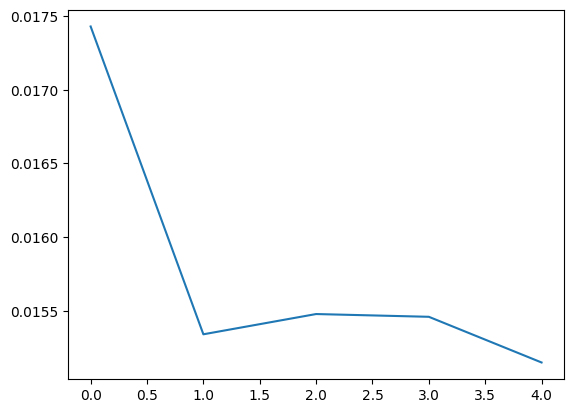

In [12]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [13]:
# Use the trained model to generate and store our test predictions
test_predictions = []

first_eval_batch = scaled_ffr_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
n=0

for i in range(len(scaled_ffr_test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # remove the first value and update the batch with the next value from the test set
    current_batch = np.append(current_batch[:,1:,:],scaled_ffr_test[n:n+1].reshape((1, 1, n_features)),axis=1)
    n += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [14]:
# Convert our predictions back to their pre scaled forms
true_predictions = scaler.inverse_transform(test_predictions)

# Apend the predictions back to the test data set
ffr_test['Predictions'] = true_predictions


<ipython-input-14-ad615baa0a20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffr_test['Predictions'] = true_predictions


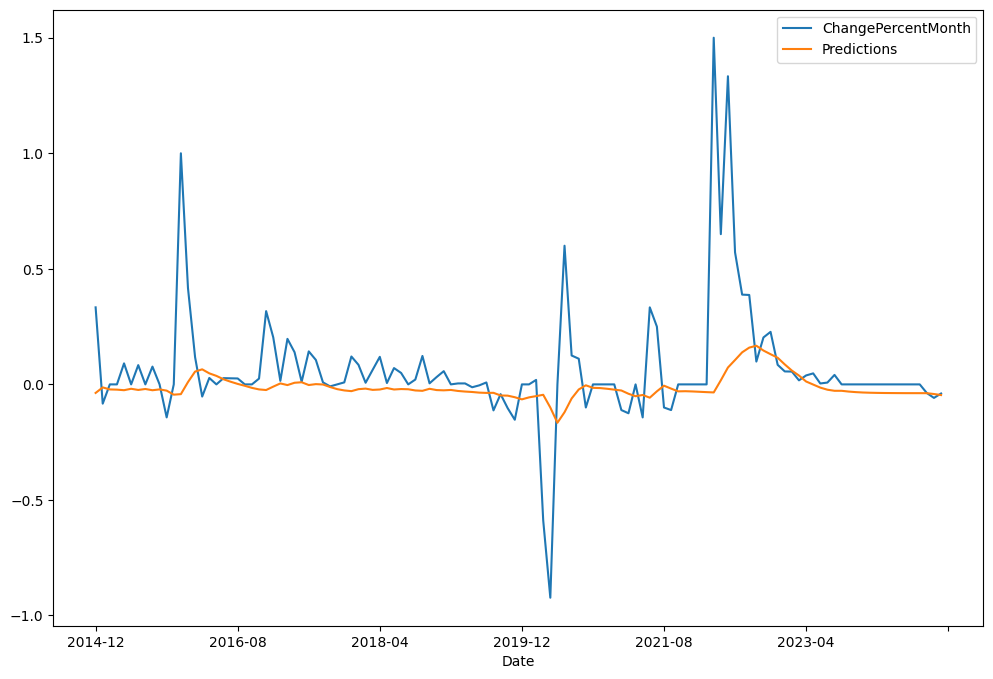

In [15]:
ffr_test.set_index('Date', inplace=True)
ffr_test.plot(figsize=(12,8))
uni_rmse=sqrt(mean_squared_error(ffr_test['ChangePercentMonth'],ffr_test['Predictions']))